In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pydicom
import torch
import numpy as np
from torch.nn import NLLLoss, Module, Linear, Dropout, LogSoftmax, Sequential, Flatten, Identity, Sigmoid, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Showing Data

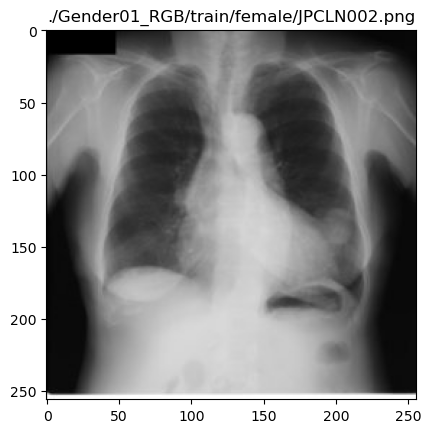

In [2]:
image_path = './Gender01_RGB/train/female/JPCLN002.png'
img = Image.open(image_path, )
plt.imshow(img, cmap='gray')
plt.title(image_path)
plt.show()

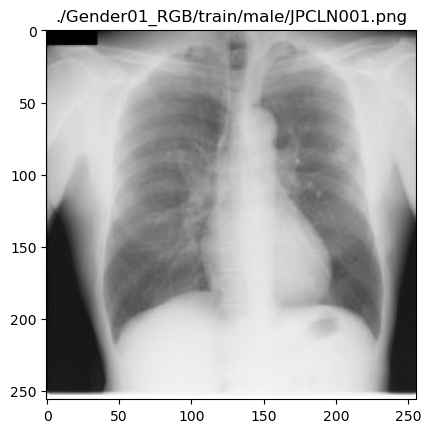

In [3]:
image_path = './Gender01_RGB/train/male/JPCLN001.png'

pixels = Image.open(image_path)

plt.imshow(pixels, cmap='gray')
plt.title(image_path)
plt.show()

# Gender

In [4]:
def parse(data_indicator):
    _, split, label, path =  data_indicator.split("\\")
    path = path.strip()
    path = path.split(',')[0]
    return split, label, path


def read_image(path):
    img = Image.open(path)
    return img


def turn_label(label):
    if label == 'female':
        return 0
    elif label == 'male':
        return 1


def do_with_data(path_for_data):
    with open(path_for_data) as fp:
        data_indicators = fp.readlines()
    
    splits, labels, paths = [], [], []
    for i in data_indicators:
        split, label, path = parse(i)
        splits.append(split)
        labels.append(label)
        paths.append(path)

    return splits, labels, paths

train_splits, train_labels, train_paths = do_with_data('./Gender01_RGB/list_train.txt')
test_splits, test_labels, test_paths = do_with_data('./Gender01_RGB/list_test.txt')


In [5]:
def prepare_data(paths, labels, splits, dataset):
    images = []
    labels_out = []
    split = splits[0]
    for path, label in zip(paths, labels):
        image = read_image(f'./{dataset}/{split}/{label}/{path}')
        images.append(image)
        labels_out.append(turn_label(label))
    index = torch.randperm(len(labels))

    # images = np.stack(images)
    labels_out = torch.tensor([labels_out[i] for i in index])
    images = [images[i] for i in index]

    return images, labels_out


# Modeling

In [6]:
class Classifier(Module):
    def __init__(self, output_size, dropout_rate):
        super(Classifier, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        in_feature = self.resnet18.fc.in_features
        self.resnet18 = Sequential(*list(self.resnet18.children())[:-1])
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            lambda t: t.to(self.get_device())
        ])

        # Apply the transformation to the image
        # tensor_image = transform(png_image)
        # self.input_size = input_size
        self.output_size = output_size 
        self.flatten = Flatten(1, -1)
        self.classifier = Linear(in_features=in_feature, out_features=output_size)
        self.dropout_rate = dropout_rate
        self.regularizer = Dropout(self.dropout_rate)
        if self.output_size == 1:
            # self.clf_func = Identity()
            self.clf_func = Sigmoid()
        # elif self.output_size == 2:
            # self.clf_func = Identity()
        else:
            self.clf_func = LogSoftmax(dim=-1)

    def get_device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = torch.stack([self.transform(i) for i in x])
        # x = self.transform(x)

        hidden = self.resnet18(x)
        hidden = self.flatten(hidden)
        
        hidden = self.classifier(hidden)
        hidden = self.regularizer(hidden)
        return self.clf_func(hidden)
        # self.resnet_features = nn.Sequential(*list(resnet18.children())

In [7]:
def train(model, x, y, optimizer, loss_fn):
    model.train()

    optimizer.zero_grad()

    y_hat = model(x)
    
    loss = loss_fn(y_hat.reshape(-1), y.to(model.get_device()).reshape(-1).float())

    loss.backward()

    optimizer.step()

    return loss.item()

In [8]:
@torch.no_grad()
def eval(model, x, y):
    model.eval()
    # print(x[0].shape)

    y_hat = model(x)
    # print(y_hat.round())
    # print(y)
    
    # print(y_hat.argmax(-1))
    # print(y)
    # return (y_hat.argmax(-1) == y.to(model.get_device())).float().mean()
    preds = (y_hat >= 0.5).reshape(-1)
    labels = y.to(model.get_device()).float().reshape(-1)
    # print(preds)
    # print(labels)
    # print(preds == labels)
    compare = preds == labels
    return compare.float().mean()
    # print((
    #     (y_hat >= 0.5) == y.to(model.get_device()).float()
    #     ).float().reshape(-1))
    return (
        (y_hat >= 0.5) == y.to(model.get_device()).float()
        ).float().mean()

# Gender Training

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classifier(1, 0.3).to(device)
lr = 3e-4
loss_fn = BCELoss()
optimizer = Adam(model.parameters(), lr=lr)
num_epochs = 25
batch_size = 32

/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


2.230134069919586
1.536116823554039
1.3513352125883102
1.091610535979271
1.1367125809192657
1.1911347061395645
0.8479639738798141
0.9430422782897949
1.1732083410024643
1.1025211215019226
1.1987634897232056
0.8587735444307327
0.9886610358953476
0.9285620525479317
1.0435262620449066
0.9769268035888672
1.0651421248912811
1.161673441529274
1.1817085593938828
1.3666015416383743
0.8651186600327492
1.2999554425477982
0.7567865177989006
1.1066175401210785
0.8467281758785248


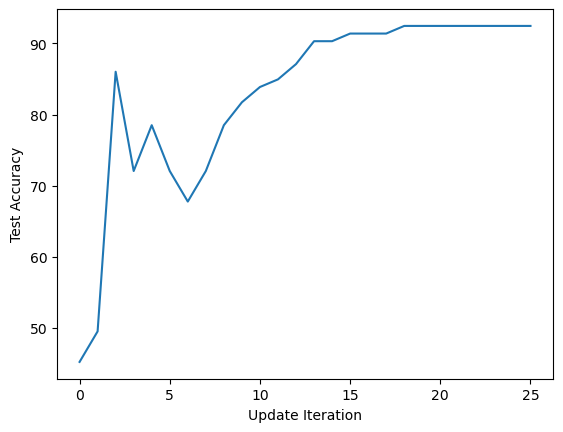

In [10]:
train_x, train_y = prepare_data(train_paths, train_labels, train_splits, dataset='Gender01_RGB')
test_x, test_y = prepare_data(test_paths, test_labels, test_splits, dataset='Gender01_RGB')

# test_x, test_y = train_x, train_y


index = torch.arange(len(train_x)).to(device)
accs = []


e = eval(model, test_x, test_y).cpu().numpy()
accs.append(e)
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_i, y in zip(
        torch.split(index, split_size_or_sections=batch_size), 
        torch.split(train_y, split_size_or_sections=batch_size)
        ):
        x = [train_x[i] for i in x_i]

        epoch_loss += train(model, x, y, loss_fn=loss_fn, optimizer=optimizer)
    e = eval(model, test_x, test_y).cpu().numpy()
    accs.append(e)
    
    print(epoch_loss)
plt.xlabel('Update Iteration')
plt.ylabel('Test Accuracy')
plt.plot(np.arange(len(accs)), np.array(accs) * 100)
plt.show()

In [11]:
accs[-1]

array(0.9247312, dtype=float32)